In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from math import sqrt
import scipy.stats

#double iteration in pandas
from itertools import product

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from windrose import WindroseAxes
import seaborn as sns; 
from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in

## SARAL-AltiKa Data

In [2]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    outliers_removed = df2
    
    """
    # remove outliers from significant wave height
    q1 = df2['swh'].quantile(0.25)
    q3 = df2['swh'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    outliers_removed = df2.loc[(df2['swh'] > fence_low) & (df2['swh'] < fence_high)]
    
    
    
    #use the standard deviation method
    
    # calculate summary statistics
    data_mean, data_std = np.mean(df2['swh']), np.std(df2['swh'])
    #identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # remove outliers
    outliers_removed = df2.loc[(df2['swh'] > lower) & (df2['swh'] < upper)]
    
    
    
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    """

    return outliers_removed

In [3]:
# import and apply the quality control to all data files

p = Path('C:/Users/panmits86/Desktop/SA_val')
#p = Path('C:/Users/panmits86/Desktop/SA_GDR')
#p = Path('C:/Users/panmits86/Desktop/Python/data/SARAL-AltiKa/SARAL_GDR_All')
# iterate the process to every data file
results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh_s = pd.concat(results)

In [5]:
swh_sa = swh_s[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa 

,time,lon,lat,swh,wind_speed_alt
0,2014-08-21 23:28:09.197778944,286.287362,40.555752,0.652,4.24
1,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36
2,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10
3,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07
4,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96
...,...,...,...,...,...
8484,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69
8485,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74
8486,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58
8487,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26


## NDBC Buoys Data

In [6]:
# input buoys coordinates (buoy_coords parameter)

buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

b44017 = (buoys['Latitude'][3],buoys['Longitude'][3]+360)
b44025 = (buoys['Latitude'][2],buoys['Longitude'][2]+360)
b44065 = (buoys['Latitude'][4],buoys['Longitude'][4]+360)
b44020 = (buoys['Latitude'][1],buoys['Longitude'][1]+360)
BUZM3 = (buoys['Latitude'][7],buoys['Longitude'][7]+360)

In [7]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

### Standard Meteorological data

In [24]:
# read all buoy data files and concatenate them into one single pandas data frame and exclude wave height error values
# input for the buoy_data parameter (e.g. b44017_wind_wave)

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017_1'
all_files = glob.glob(path + "/*.txt")

b44017_wind_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wind_wave = b44017_wind_wave[(b44017_wind_wave.WVHT !=99) & (b44017_wind_wave.WVHT > 0.1) &
                                   (b44017_wind_wave.WSPD !=99) & (b44017_wind_wave.WSPD > 0.1)]
b44017_wind_wave.reset_index(inplace=True)
b44017_wind_wave.drop('index', 1, inplace=True)
#b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*(10/4.1)**0.11
b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))

### Continuous Winds Dataset

In [8]:
# read all buoy data files and concatenate them into one single pandas data frame and exclude wave height error values
# input for the buoy_data parameter (e.g. b44017_wind)

path = r'C:/Users/panmits86/Desktop/Continuous_Winds/Station_44017'
all_files = glob.glob(path + "/*.txt")

b44017_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wind = b44017_wind[(b44017_wind.WSPD !=99) & (b44017_wind.WSPD > 0.1)]
b44017_wind.reset_index(inplace=True)
b44017_wind.drop('index', 1, inplace=True)
#b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*(10/4.1)**0.11
b44017_wind['u10'] = b44017_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))

In [25]:
# input for the buoy_time parameter

b44017_time = b44017_wind_wave['Date']
#b44025_time = b44025_wind['Date']
#b44065_time = b44065_wind['Date']
#BUZM3_time = BUZM3_wind['Date']
#b44020_time = b44020_wind['Date']

In [10]:
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]

In [30]:
# Set the sampling radius in kilometers and the time window in minutes

radius = 10
time_window = 5

In [ ]:
# Collocation algorithm for the continuous winds dataset

def collocation(buoy_coords,radius_km,buoy_data,buoy_time,time_window_min):
    hav5 = haversine_vector([buoy_coords]*swh_sa.shape[0],a1, Unit.KILOMETERS)
    swh_sa['Buoy-Sat. Distance (km)'] = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])

    radius = swh_sa['Buoy-Sat. Distance (km)'] < radius_km
    colocated = swh_sa[radius]
    colocated.reset_index(inplace=True)
    colocated.drop('index', 1, inplace=True)

    col = colocated['Buoy-Sat. Distance (km)'].to_numpy()

    sat_time = colocated['time'].reset_index()
    sat_time.drop('index', 1, inplace=True)
    
    b = colocated.to_numpy()
    c = buoy_data.to_numpy()

    bb1 = np.tile(b,(c.shape[0],1))
    cc1 = np.repeat(c,b.shape[0],axis=0)

    sat = sat_time['time'].to_numpy()
    buoy = buoy_time.to_numpy()

    buoy1 = buoy[:,np.newaxis]

    a = sat-buoy1
    aa = a/np.timedelta64(1,'m')

    aaa = np.ravel(aa)
    aaaa1 = aaa[:,np.newaxis]
    
    dd1=np.concatenate((cc1,bb1,aaaa1),axis=1)
    
    ddd1 = dd1[np.where(np.absolute(dd1[:,10])<time_window_min)]
    dddd1 = pd.DataFrame(ddd1)
    dddd1.columns = ['Buoy Time','Buoy Wind Speed', 'Buoy U10', 'SARAL-AltiKa Time', 'SARAL lon', 'SARAL lat',
                'SARAL-AltiKa Wave Height', 'SARAL-AltiKa Wind Speed', 'Buoy-Sat. Distance (km)', 'Time Difference (min.)']
    
    collocated_data = dddd1
    
    return collocated_data

In [31]:
# Collocation algorithm for the standard meteorological dataset

def collocation(buoy_coords,radius_km,buoy_data,buoy_time,time_window_min):
    hav5 = haversine_vector([buoy_coords]*swh_sa.shape[0],a1, Unit.KILOMETERS)
    swh_sa['Buoy-Sat. Distance (km)'] = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])

    radius = swh_sa['Buoy-Sat. Distance (km)'] < radius_km
    colocated = swh_sa[radius]
    colocated.reset_index(inplace=True)
    colocated.drop('index', 1, inplace=True)

    col = colocated['Buoy-Sat. Distance (km)'].to_numpy()

    sat_time = colocated['time'].reset_index()
    sat_time.drop('index', 1, inplace=True)
    
    b = colocated.to_numpy()
    c = buoy_data.to_numpy()

    bb1 = np.tile(b,(c.shape[0],1))
    cc1 = np.repeat(c,b.shape[0],axis=0)

    sat = sat_time['time'].to_numpy()
    buoy = buoy_time.to_numpy()

    buoy1 = buoy[:,np.newaxis]

    a = sat-buoy1
    aa = a/np.timedelta64(1,'m')

    aaa = np.ravel(aa)
    aaaa1 = aaa[:,np.newaxis]
    
    dd1=np.concatenate((cc1,bb1,aaaa1),axis=1)
    
    ddd1 = dd1[np.where(np.absolute(dd1[:,10])<time_window_min)]
    dddd1 = pd.DataFrame(ddd1)
    dddd1.columns = ['Buoy Time','Buoy Wind Speed','Buoy Hs', 'Buoy U10', 'SARAL-AltiKa Time', 'SARAL lon', 'SARAL lat',
                'SARAL-AltiKa Wave Height', 'SARAL-AltiKa Wind Speed', 'Buoy-Sat. Distance (km)', 'Time Difference (min.)']
    
    collocated_data = dddd1
    
    return collocated_data

In [32]:
# final collocated data with all the parameters

data = collocation(b44017,radius,b44017_wind,b44017_time,time_window)

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
# merge collocated data from different buoys (optional)

merge = [data1,data2,data3,data4]
saral_wind = pd.concat(merge)
saral_wind

## Regression Analysis

In [17]:
data1 = data.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df = data1.iloc[:,[1,6]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.resample('D').mean()
df = df.dropna()

In [18]:
# Calculate Bias 

df['u10 Difference'] = df['SARAL-AltiKa Wind Speed'] - df['Buoy U10']

bias = abs(df["u10 Difference"].sum() / len(df))
bias

0.024899060139653706

In [19]:
# Linear Regression

x = df['Buoy U10']

xx = df['SARAL-AltiKa Wind Speed']

model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], xx)

x1fit = np.linspace(0, 20, len(df))
y1fit = model.predict(x1fit[:, np.newaxis])

In [21]:
# Statistics of the Regression line

a=model.coef_
b=model.intercept_

scores_mean = list()
scores_std = list()

scores = cross_validate(model, x[:, np.newaxis], xx, scoring=['r2', 'neg_root_mean_squared_error'], cv=10)

rsquared = np.mean(scores['test_r2'])
rmse = -np.mean(scores['test_neg_root_mean_squared_error'])
rmsee = np.std(scores['test_neg_root_mean_squared_error'])
N=len(df)

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWa

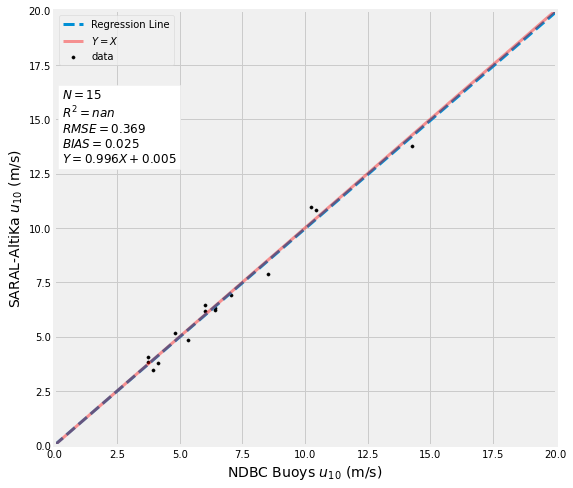

In [23]:
# Plot the results

fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x, xx, s=10, color='k', label='data')
plt.plot(x1fit, y1fit, linewidth=3, linestyle='--', label='Regression Line')
plt.plot([0, 20], [0, 20], linestyle='-', linewidth=3, color='r', alpha=0.4, label='$Y=X$')

plt.xlabel('Buoy 44017 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $u_{10} \ (m/s)$', fontsize=14)

"""
extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
                                                      
"""

plt.xlabel('NDBC Buoys $u_{10}$ (m/s)', fontsize=14)
plt.ylabel('SARAL-AltiKa $u_{10}$ (m/s)', fontsize=14)

plt.xlim(0,20)
plt.ylim(0,20)

props = dict(boxstyle='square', facecolor='white', alpha=1)

textstr = '\n'.join((r'$N=%i$' % (N,), r'$R^2=%.3f$' % (rsquared,), r'$RMSE=%.3f$' % (rmse,), r'$BIAS=%.3f$' % (bias,) 
                     , r'$Y=%.3fX + %.3f$' % (a,b,)))

ax.text(0.3,13,textstr,fontsize=12,bbox=props)

ax.legend(loc='best')

#plt.savefig('SARAL_Val_Wind_BUZM3.png', dpi=300, bbox_inches='tight')